# Module 3 Project - London Air Quality analysis

1. [Introduction](#intro)
2. [Exploratory Data Analysis](#EDA)
3. [Cleaning](#Cleaning)
4. [Statistical Analysis](#stats)
5. [Discussion](#disc)



<a id='intro'></a>

1. Introduction

    - background about project
    - motivation
    - hypotheses

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats as sms
# from functions import APICaller
import seaborn as sns
import matplotlib.pyplot as plt
import requests as req
import time
import scipy.stats as stats
sns.set_style('darkgrid')

In [2]:
# first testing of data retrieval from 1st API
location1 = 'LH0'
date = '2008-06-01'
url_extension = '/Daily/MonitoringIndex/SiteCode='
openaq_caller = APICaller(base_url='http://api.erg.kcl.ac.uk/AirQuality', ignore_token=True)

test_resp = openaq_caller.retrieve_one(url_extension,location=location1, date=date)

test_resp

NameError: name 'APICaller' is not defined

In [ ]:
#  retrieve name of species (pollutants);
url_for_species = '/Information/Species/Json'
# species_list = openaq_caller.retrieve_one(url_extension=url_for_species)
#  http://api.erg.kcl.ac.uk/AirQuality/Information/Species/Json
base_url='http://api.erg.kcl.ac.uk/AirQuality'
def retrieve_one(main_url,url_extension,location=None, date=None, date1=None):  
        if date1!=None:
            response = req.get(main_url+url_extension+f'{location}/StartDate={date}/EndDate={date1}/Json').json()
        elif (date!=None and date1==None):
            response = req.get(main_url+url_extension+f'{location}/Date={date}/Json').json()
        else:
            print(base_url+url_extension)
            response = req.get(main_url+url_extension).json()
        return response
    
    
retrieve_one(main_url=base_url, url_extension=url_for_species)

In [ ]:
url_for_sites = '/MonitoringIndex/GroupName={GroupName}/Json'
url_for_daily_1_date = '/Daily/MonitoringIndex/GroupName={GroupName}/Date=2018/06/03/Json'
# retrieve_one(main_url=base_url, url_extension=url_for_daily_1_date, )

print(req.get(base_url + url_for_sites))

In [ ]:
def retrieve_many(main_url,url_ext,location_list,species, start_date_list, end_date_list):
        data = []
        counter=0
        for i in range(len(start_date_list)):
            for location in location_list:
                response = req.get(f'{main_url}{url_ext}/SiteCode={location}/SpeciesCode={species}/StartDate={start_date_list[i]}/EndDate={end_date_list[i]}/Json').json()
                data.append(response)
                counter+=1
            data_df = pd.read_json(data)    
            return data_df
    


In [ ]:
response = req.get('http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode=CT3/SpeciesCode=NO2/StartDate=2006/05/01/EndDate=2006/05/02/csv')

print(response)

In [ ]:
# will set loop to run over multiple dates
base_url='http://api.erg.kcl.ac.uk/AirQuality'
location_list0 = ['LH0','ZR2', 'BL0', 'EN4', 'CT3', 'RI1']
species_code='NO2'
url_data = '/Data/SiteSpecies'
start_dates = ['2006/05/01', '2006/10/01']
end_dates = ['2006/06/01', '2006/11/01']

NO2_LEZ = retrieve_many(main_url=base_url, url_ext = url_data, location_list=location_list0, species=species_code, start_date_list = start_dates, end_date_list = end_dates)

In [ ]:
# API failed to work after many attempts. Might go back to this. Will just use CSV downloaded data for now. 

In [3]:
df_no2 = pd.read_csv('LaqnData_no2.csv')
print(df_no2.shape)
df_no2.head()

(30312, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,NO2,01/01/2006 00:00,37.4,ug m-3,R
1,CT3,NO2,02/01/2006 00:00,39.8,ug m-3,R
2,CT3,NO2,03/01/2006 00:00,57.5,ug m-3,R
3,CT3,NO2,04/01/2006 00:00,51.0,ug m-3,R
4,CT3,NO2,05/01/2006 00:00,50.7,ug m-3,R


In [4]:
df_no2.describe()

,Value
count,28078.000000
mean,42.255673
std,17.988358
min,3.500000
25%,28.900000
50%,40.500000
75%,53.300000
max,168.899990


In [5]:
df_no2.Site.value_counts(dropna=False)

CT3    5052
RI1    5052
BL0    5052
EN4    5052
LH0    5052
ZR2    5052
Name: Site, dtype: int64

In [6]:
# convert strings to datetime objects

df_no2.ReadingDateTime = pd.to_datetime(df_no2.ReadingDateTime)
df_no2.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,NO2,2006-01-01,37.4,ug m-3,R
1,CT3,NO2,2006-02-01,39.8,ug m-3,R
2,CT3,NO2,2006-03-01,57.5,ug m-3,R
3,CT3,NO2,2006-04-01,51.0,ug m-3,R
4,CT3,NO2,2006-05-01,50.7,ug m-3,R


In [7]:
# check number of missing values

df_no2.isna().sum()

Site                          0
Species                       0
ReadingDateTime               0
Value                      2234
Units                         0
Provisional or Ratified       0
dtype: int64

In [8]:
df_no2.loc[(df_no2).Value.isnull()].head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
46,CT3,NO2,2006-02-16,NaN,ug m-3,R
47,CT3,NO2,2006-02-17,NaN,ug m-3,R
204,CT3,NO2,2006-07-24,NaN,ug m-3,R
205,CT3,NO2,2006-07-25,NaN,ug m-3,R
206,CT3,NO2,2006-07-26,NaN,ug m-3,R


In [9]:
# delete the rows with Nan value for the df_no2 DataFrame

df_no2.dropna(inplace=True)
print(df_no2.shape)
df_no2.tail()

(28078, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
30307,EN4,NO2,2019-10-27,31.7,ug m-3,P
30308,EN4,NO2,2019-10-28,41.1,ug m-3,P
30309,EN4,NO2,2019-10-29,39.8,ug m-3,P
30310,EN4,NO2,2019-10-30,38.3,ug m-3,P
30311,EN4,NO2,2019-10-31,38.9,ug m-3,P


In [10]:
# create year column

df_no2['Year'] = df_no2.ReadingDateTime.dt.year
df_no2.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year
0,CT3,NO2,2006-01-01,37.4,ug m-3,R,2006
1,CT3,NO2,2006-02-01,39.8,ug m-3,R,2006
2,CT3,NO2,2006-03-01,57.5,ug m-3,R,2006
3,CT3,NO2,2006-04-01,51.0,ug m-3,R,2006
4,CT3,NO2,2006-05-01,50.7,ug m-3,R,2006


In [11]:
df_no2['Provisional or Ratified'].value_counts()

R    26702
P     1376
Name: Provisional or Ratified, dtype: int64

In [12]:
# create new dataframe with only the value and year columns

df_no2_new = df_no2.drop(['Site','Species','ReadingDateTime','Units','Provisional or Ratified'],axis=1)
df_no2_new.head()

,Value,Year
0,37.4,2006
1,39.8,2006
2,57.5,2006
3,51.0,2006
4,50.7,2006


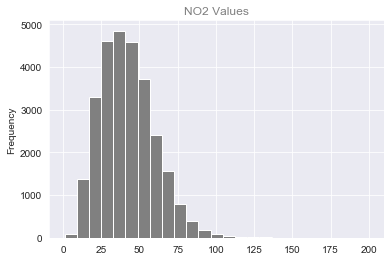

In [13]:
# make a frequency barplot

df_no2.Value.plot.hist(range=(1, 200), bins=25, color='grey')
plt.title('NO2 Values', color = 'grey')
plt.show()

In [14]:
# create PM10 particulates DataFrame

df_pm10 = pd.read_csv('LaqnData_pm10.csv')
print(df_pm10.shape)
df_pm10.head()

(30312, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,PM10,01/01/2006 00:00,7.0,ug/m3,R
1,CT3,PM10,02/01/2006 00:00,14.0,ug/m3,R
2,CT3,PM10,03/01/2006 00:00,19.0,ug/m3,R
3,CT3,PM10,04/01/2006 00:00,18.0,ug/m3,R
4,CT3,PM10,05/01/2006 00:00,20.0,ug/m3,R


In [15]:
# check number of sites 

df_pm10.Site.value_counts(dropna=False)

CT3    5052
RI1    5052
BL0    5052
EN4    5052
LH0    5052
ZR2    5052
Name: Site, dtype: int64

In [16]:
len(df_pm10)

30312

In [17]:
df_pm10.loc[df_pm10.Value.isna()]
# given that we have ~4600 NaN values amongst nearly 30k values, we can drop them

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
46,CT3,PM10,16/02/2006 00:00,NaN,ug/m3,R
47,CT3,PM10,17/02/2006 00:00,NaN,ug/m3,R
48,CT3,PM10,18/02/2006 00:00,NaN,ug/m3,R
49,CT3,PM10,19/02/2006 00:00,NaN,ug/m3,R
50,CT3,PM10,20/02/2006 00:00,NaN,ug/m3,R
...,...,...,...,...,...,...
30307,EN4,PM10,27/10/2019 00:00,NaN,ug/m3,P
30308,EN4,PM10,28/10/2019 00:00,NaN,ug/m3,P
30309,EN4,PM10,29/10/2019 00:00,NaN,ug/m3,P
30310,EN4,PM10,30/10/2019 00:00,NaN,ug/m3,P


In [18]:
df_pm10 = df_pm10.dropna()

In [19]:
df_pm10.loc[df_pm10.Value.isna()]


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified


In [20]:
df_pm10.ReadingDateTime = pd.to_datetime(df_pm10.ReadingDateTime)
df_pm10.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,PM10,2006-01-01,7.0,ug/m3,R
1,CT3,PM10,2006-02-01,14.0,ug/m3,R
2,CT3,PM10,2006-03-01,19.0,ug/m3,R
3,CT3,PM10,2006-04-01,18.0,ug/m3,R
4,CT3,PM10,2006-05-01,20.0,ug/m3,R


In [21]:
df_pm10['Year'] = df_pm10.ReadingDateTime.dt.year
df_pm10.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year
0,CT3,PM10,2006-01-01,7.0,ug/m3,R,2006
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2006
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,2006
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,2006
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,2006


In [22]:
# create new dataframe with only the value and year columns

df_pm10_new = df_pm10.drop(['Site','Species','ReadingDateTime','Units','Provisional or Ratified'],axis=1)
df_pm10_new.head()

,Value,Year
0,7.0,2006
1,14.0,2006
2,19.0,2006
3,18.0,2006
4,20.0,2006


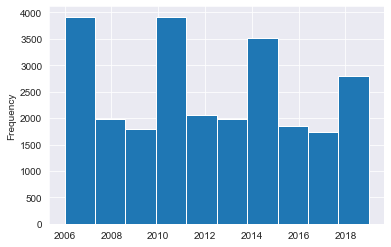

In [23]:
df_pm10_new['Year'].plot.hist()
# given that the data across time is non-uniform, for unknown reasons, we'll be trying to select pre- and post-ULEZ 
# data from 2006,2010,2014 and 2018

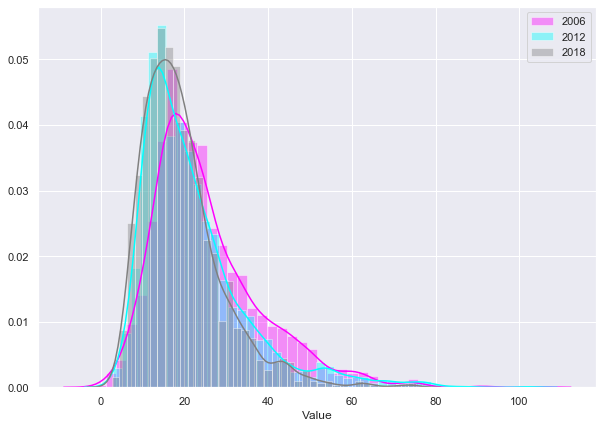

In [24]:
sns.set_color_codes('dark')
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2006]['Value'], color='magenta')
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2012]['Value'], color='cyan')
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2018]['Value'], color='grey')
plt.legend(labels=['2006', '2012', '2018'])

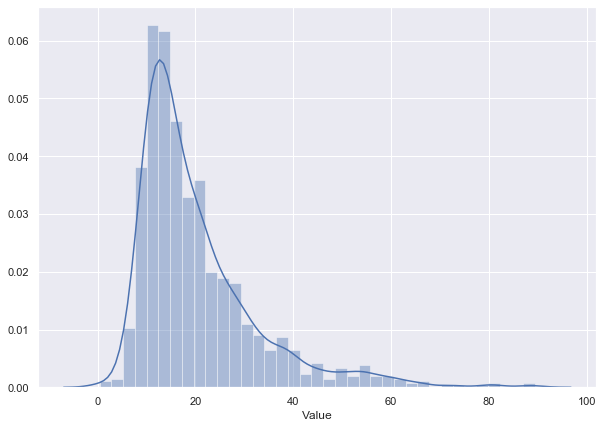

In [25]:
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2019]['Value'])

In [26]:
df_pm10.head(20)

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year
0,CT3,PM10,2006-01-01,7.0,ug/m3,R,2006
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2006
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,2006
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,2006
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,2006
5,CT3,PM10,2006-06-01,28.0,ug/m3,R,2006
6,CT3,PM10,2006-07-01,33.0,ug/m3,R,2006
7,CT3,PM10,2006-08-01,34.0,ug/m3,R,2006
8,CT3,PM10,2006-09-01,36.0,ug/m3,R,2006
9,CT3,PM10,2006-10-01,21.0,ug/m3,R,2006


In [27]:
df_pm10['Month'] = df_pm10.ReadingDateTime.dt.month
df_pm10

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year,Month
0,CT3,PM10,2006-01-01,7.0,ug/m3,R,2006,1
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2006,2
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,2006,3
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,2006,4
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,2006,5
...,...,...,...,...,...,...,...,...
28976,EN4,PM10,2016-05-03,25.8,ug/m3,R,2016,5
28977,EN4,PM10,2016-06-03,26.4,ug/m3,R,2016,6
28978,EN4,PM10,2016-07-03,30.2,ug/m3,R,2016,7
28979,EN4,PM10,2016-08-03,34.9,ug/m3,R,2016,8


In [28]:
df_no2['Month'] = df_no2.ReadingDateTime.dt.month
df_no2

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year,Month
0,CT3,NO2,2006-01-01,37.4,ug m-3,R,2006,1
1,CT3,NO2,2006-02-01,39.8,ug m-3,R,2006,2
2,CT3,NO2,2006-03-01,57.5,ug m-3,R,2006,3
3,CT3,NO2,2006-04-01,51.0,ug m-3,R,2006,4
4,CT3,NO2,2006-05-01,50.7,ug m-3,R,2006,5
...,...,...,...,...,...,...,...,...
30307,EN4,NO2,2019-10-27,31.7,ug m-3,P,2019,10
30308,EN4,NO2,2019-10-28,41.1,ug m-3,P,2019,10
30309,EN4,NO2,2019-10-29,39.8,ug m-3,P,2019,10
30310,EN4,NO2,2019-10-30,38.3,ug m-3,P,2019,10


In [29]:
# For our comparison groups we will be selecting Sites, Species, Value, Units, Year and Month for May and Oct 2006 & 2009
test_df_no2 = df_no2.loc[(df_no2.Month == 5)|(df_no2.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])
test_df_pm10 = df_pm10.loc[(df_pm10.Month == 5)|(df_pm10.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])

test_df_no2.head()

,Site,Species,Value,Units,Year,Month
4,CT3,NO2,50.7,ug m-3,2006,5
9,CT3,NO2,31.0,ug m-3,2006,10
35,CT3,NO2,71.1,ug m-3,2006,5
40,CT3,NO2,71.1,ug m-3,2006,10
63,CT3,NO2,68.0,ug m-3,2006,5


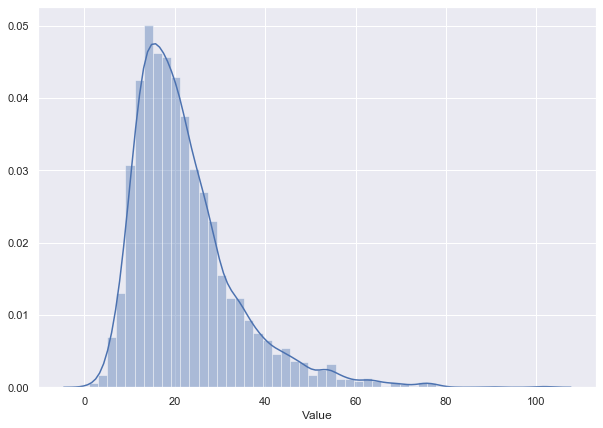

In [30]:
sns.distplot(test_df_pm10.Value)

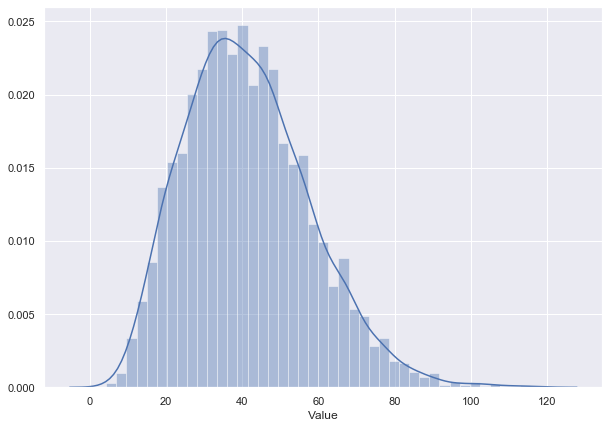

In [31]:
sns.distplot(test_df_no2.Value)

In [32]:
len(test_df_pm10)

4383

In [33]:
len(test_df_no2)

4798

In [34]:
len(test_df_no2.loc[test_df_no2['Year']==2006])

350

In [35]:
len(test_df_no2.loc[test_df_no2['Year']==2009])

340

In [36]:
# Now we make our testing samples below, for May and Oct 2006, 2009, for both the PM10 and the NO2 values. 
pre_lez_no2 = test_df_no2.loc[test_df_no2['Year']==2006]
post_lez_no2 = test_df_no2.loc[test_df_no2['Year']==2009]

pre_lez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2006]
post_lez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2009]

In [48]:
pre_lez_no2.Site.value_counts()

RI1    62
EN4    62
LH0    60
BL0    59
CT3    59
ZR2    48
Name: Site, dtype: int64

Testing for normality of our samples using stats.shapiro

In [50]:
stats.shapiro(pre_lez_no2.Value)

(0.9797401428222656, 7.775388075970113e-05)

In [55]:
samples = [pre_lez_no2.Value, post_lez_no2.Value, pre_lez_pm10.Value, post_lez_pm10.Value]

for sample in samples:
    print(stats.shapiro(sample))



(0.9797401428222656, 7.775388075970113e-05)
(0.988274335861206, 0.007663216907531023)
(0.8767014741897583, 7.2833848505335125e-16)
(0.8969574570655823, 2.2006795528679152e-13)


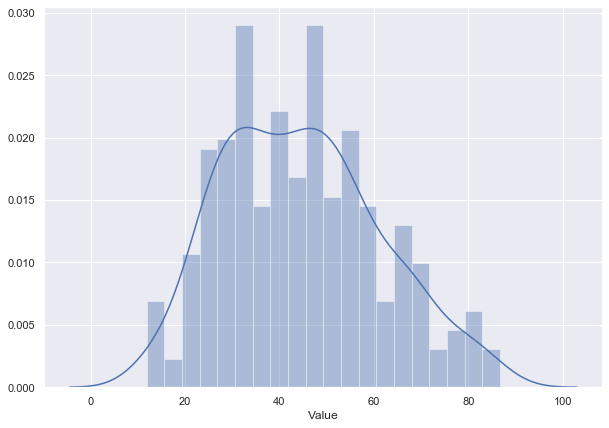

In [57]:
sns.distplot(pre_lez_no2.Value,bins=20)

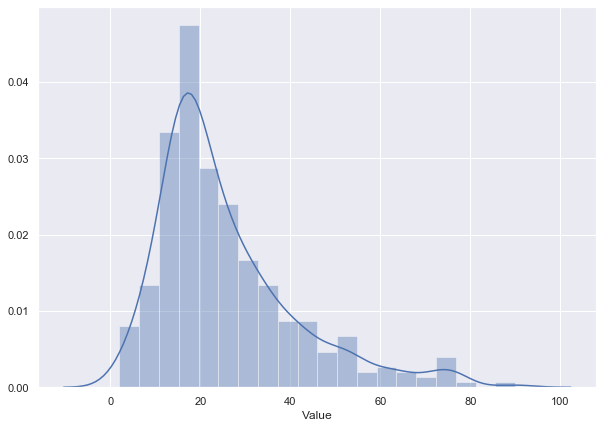

In [58]:
sns.distplot(pre_lez_pm10.Value,bins=20)

## Statistical Testing

(Mina)

1. The introducton of ULEZ (8th April 2019) decreased the amount of NOx in Zone 1 of Central London by at least 42%. 
[H0] - ULEZ reduced the amount of NOx in Zone 1 by less than 42%.
2. The introduction of ULEZ was at least 25% more effective than the introduction of LEZ (4th February 2008) in reducing NOx levels in Central London.
[H0] - The effect of ULEZ on NOx levels was less than 25% more than the impact of LEZ. 

(Ioana) 
3. The introducton of ULEZ decreased the amount of PM10 in Zone 1 of Central London by at least 33%. 
[H0] - ULEZ reduced the amount of PM10 in Zone 1 by less than 33%.
4. The introduction of ULEZ was at least 25% more effective than the introduction of LEZ in reducing PM10 levels in Central London. 
[H0] - The effect of ULEZ on PM10 levels was less than 25% more than the impact of LEZ. 

Our alpha values are set at 0.05.

In [37]:
def sample_variance(sample):
    return np.sum([(x - np.mean(sample))**2 for x in sample])/(len(sample)-1)

def pooled_variance(sample1, sample2):
    return ((len(sample1)-1)*sample_variance(sample1) + (len(sample2)-1)*sample_variance(sample2))/(len(sample1) + len(sample2) - 2)


def visualize_t(t_stat, n_control, n_experimental):
    df = len(n_experimental)-1
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4,4,200)
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys = stats.t.pdf(xs, df, 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkblue')

    # Draw two sided boundary for critical-t
    ax.axvline(x=+t_stat, color='red', linestyle='--', lw=3,label='t-statistic_lower_bound')
    ax.axvline(x=-t_stat, color='purple', linestyle='--', lw=3,label='t-statistic_upper_bound')
    ax.legend()
    plt.show()
    return 

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    # Calculate the pooled threshold as shown earlier
    pooled_var = pooled_variance(group1, group2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d


def welch_t_test(sample1,sample2):
    num = np.mean(sample1)-np.mean(sample2)
    denom = np.sqrt((sample_variance(sample1)**2/len(sample1)) + (sample_variance(sample2)**2/len(sample2)))
    return num/denom
 
def welch_t(sample1, sample2):
    numerator = np.mean(sample1) - np.mean(sample2)   
    denominator = np.sqrt(np.var(sample1)/len(sample1) + np.var(sample2)/len(sample2))
    return np.abs(numerator/denominator)    

def welch_dof(sample1,sample2):
    s1 = np.var(sample1)
    s2 = np.var(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    
    num = (s1/n1 + s2/n2)**2
    denom = (s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1)
    return num/denom
              
def p_val(t_stat, df):
    return 1-stats.t.cdf(t_stat,df)

In [38]:
p_val(welch_t(pre_lez_no2.Value, post_lez_no2.Value), welch_dof(pre_lez_no2.Value, post_lez_no2.Value))

1.274178082932842e-05

In [39]:
p_val(welch_t(pre_lez_pm10.Value, post_lez_pm10.Value), welch_dof(pre_lez_pm10.Value, post_lez_pm10.Value))

0.05187223585945344

In [54]:
stats.ttest_ind(pre_lez_no2.Value, post_lez_no2.Value, equal_var=False)

Ttest_indResult(statistic=-4.233553917274355, pvalue=2.6173449672710944e-05)

In [53]:
stats.ttest_ind(pre_lez_pm10.Value, post_lez_pm10.Value, equal_var=False)

Ttest_indResult(statistic=1.6270160572384869, pvalue=0.10427480261752126)

In [42]:
print("The effect of LEZ on the levels of NO2 in the City of London: ", Cohen_d(pre_lez_no2.Value, post_lez_no2.Value))

The effect of LEZ on the levels of NO2 in the City of London:  -0.3227949581974283


Having conducted our statistical significance test for LEZ, we conclude that there was a significant impact on NO2 levels due to LEZ, but our p-value for the PM10 levels was so large that we cannot reject the null hypothesis that LEZ had no impact on PM10. Given that we're trying to compare ULEZ to LEZ impact, we will return to the PM10 levels once we have conducted our tests on the ULEZ dates

In [44]:
len(pre_ulez_no2)

366

In [45]:
len(post_ulez_no2)

273

In [46]:
len(pre_ulez_pm10)

302

In [47]:
len(post_ulez_pm10)

215

In [59]:
pre_ulez_no2.Site.value_counts()

BL0    62
RI1    62
LH0    62
EN4    62
CT3    60
ZR2    58
Name: Site, dtype: int64

For our pre- and post-ULEZ comparisons we'll be using a different batch of data. 

In [61]:
city_df_pm10 = pd.read_csv('city_pm10.csv')
city_df_no2 = pd.read_csv('city_no2.csv')

In [91]:
city_df_pm10.Site.value_counts()

CT8    8588
HK6    4716
CT3    4702
MY7    4261
WM6    1566
Name: Site, dtype: int64

In [92]:
city_df_no2.Site.value_counts()

KC1    9658
CT3    4840
HK6    4762
CT6    4339
WM6    2204
Name: Site, dtype: int64

In [90]:
city_df_pm10.loc[city_df_pm10.duplicated(subset=['Site'])]

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Month,Year
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2,2006
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,3,2006
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,4,2006
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,5,2006
5,CT3,PM10,2006-06-01,28.0,ug/m3,R,6,2006
...,...,...,...,...,...,...,...,...
30307,WM6,PM10,2019-10-27,20.0,ug/m3,P,10,2019
30308,WM6,PM10,2019-10-28,27.0,ug/m3,P,10,2019
30309,WM6,PM10,2019-10-29,18.0,ug/m3,P,10,2019
30310,WM6,PM10,2019-10-30,30.0,ug/m3,P,10,2019


In [85]:
city_df_no2.loc[city_df_no2.duplicated()]

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Month,Year
25260,KC1,NO,2006-01-01,4.5,ug m-3,R,1,2006
25261,KC1,NO,2006-02-01,21.9,ug m-3,R,2,2006
25262,KC1,NO,2006-03-01,28.9,ug m-3,R,3,2006
25263,KC1,NO,2006-04-01,22.3,ug m-3,R,4,2006
25264,KC1,NO,2006-05-01,20.7,ug m-3,R,5,2006
...,...,...,...,...,...,...,...,...
30307,KC1,NO,2019-10-27,12.1,ug m-3,P,10,2019
30308,KC1,NO,2019-10-28,49.9,ug m-3,P,10,2019
30309,KC1,NO,2019-10-29,4.0,ug m-3,P,10,2019
30310,KC1,NO,2019-10-30,7.4,ug m-3,P,10,2019


In [63]:
# cleaning the data as before
city_df_pm10.tail()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
30307,WM6,PM10,27/10/2019 00:00,20.0,ug/m3,P
30308,WM6,PM10,28/10/2019 00:00,27.0,ug/m3,P
30309,WM6,PM10,29/10/2019 00:00,18.0,ug/m3,P
30310,WM6,PM10,30/10/2019 00:00,30.0,ug/m3,P
30311,WM6,PM10,31/10/2019 00:00,41.0,ug/m3,P


In [69]:
len(city_df_pm10)

30312

In [70]:
len(city_df_no2)

30312

In [68]:
print(len(city_df_pm10.loc[city_df_pm10.Value.isna()]))
print(len(city_df_no2.loc[city_df_no2.Value.isna()]))

6479
4509


In [76]:
city_df_pm10 = city_df_pm10.dropna()
city_df_no2 = city_df_no2.dropna()

# city_df_pm10 = city_df_pm10.

city_df_pm10.ReadingDateTime = pd.to_datetime(city_df_pm10.ReadingDateTime)
city_df_no2.ReadingDateTime = pd.to_datetime(city_df_no2.ReadingDateTime)

city_df_pm10['Year'] = city_df_pm10.ReadingDateTime.dt.year
city_df_no2['Year'] = city_df_no2.ReadingDateTime.dt.year

city_df_pm10['Month'] = city_df_pm10.ReadingDateTime.dt.month
city_df_no2['Month'] = city_df_no2.ReadingDateTime.dt.month


In [77]:
ulez_test_df_no2 = city_df_no2.loc[(city_df_no2.Month == 5)|(city_df_no2.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])
ulez_test_df_pm10 = city_df_pm10.loc[(city_df_pm10.Month == 5)|(city_df_pm10.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])

ulez_test_df_no2.tail()

,Site,Species,Value,Units,Month,Year
30307,KC1,NO,12.1,ug m-3,10,2019
30308,KC1,NO,49.9,ug m-3,10,2019
30309,KC1,NO,4.0,ug m-3,10,2019
30310,KC1,NO,7.4,ug m-3,10,2019
30311,KC1,NO,17.9,ug m-3,10,2019


In [78]:
pre_ulez_no2 = ulez_test_df_no2.loc[ulez_test_df_no2['Year']==2018]
post_ulez_no2 = ulez_test_df_no2.loc[ulez_test_df_no2['Year']==2019]

pre_ulez_pm10 = ulez_test_df_pm10.loc[ulez_test_df_pm10['Year']==2018]
post_ulez_pm10 = ulez_test_df_pm10.loc[ulez_test_df_pm10['Year']==2019]

In [79]:
stats.ttest_ind(pre_ulez_no2.Value, post_ulez_no2.Value, equal_var=False)

Ttest_indResult(statistic=4.231541338133171, pvalue=2.6649469955547735e-05)

In [80]:
stats.ttest_ind(pre_ulez_pm10.Value, post_ulez_pm10.Value, equal_var=False)

Ttest_indResult(statistic=8.483597601594548, pvalue=2.2246100032624727e-16)

In [81]:
print("The effect of ULEZ on the levels of NO2 in the City of London: ", Cohen_d(pre_ulez_no2.Value, post_ulez_no2.Value))

The effect of ULEZ on the levels of NO2 in the City of London:  0.31888741475790605


In [82]:
print("The effect of ULEZ on the levels of PM10 in the City of London: ", Cohen_d(pre_ulez_pm10.Value, post_ulez_pm10.Value))

The effect of ULEZ on the levels of PM10 in the City of London:  0.6937046100406896
